=== DUTCH PROTEIN DIETS: FOOD-FEED COMPETITION ===

=== SCENARIO SUMMARY ===
              soy_land_pc  total_land_pc   water_pc  protein_pc
scenario                                                       
Current            312.46         981.85  815306.28       28.43
Red meat cap       225.08         659.77  544023.72       22.21
50/50              200.68         447.16  397204.69       22.00
40/60              194.95         399.34  363072.20       22.00

=== Full Scenario Summary Table ===
              soy_land_pc  total_land_pc   water_pc  protein_pc  beef_kg  \
scenario                                                                   
Current            312.46         981.85  815306.28       28.43    14.90   
Red meat cap       225.08         659.77  544023.72       22.21     2.98   
50/50              200.68         447.16  397204.69       22.00     1.79   
40/60              194.95         399.34  363072.20       22.00     1.38   

              chicken_kg  dairy_kg  eggs_kg  

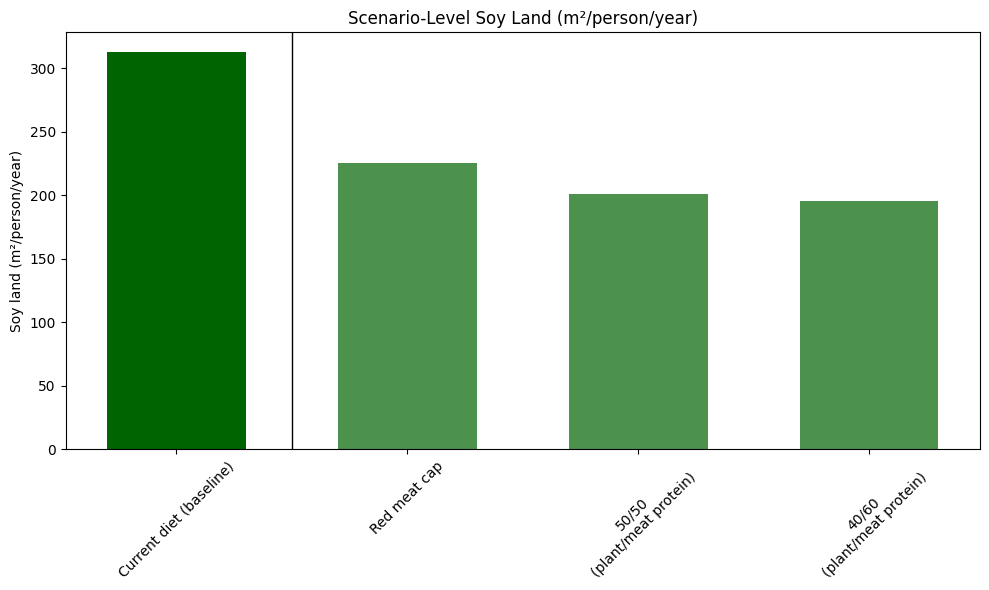


=== Summary Table: Soy Land ===
scenario
Current diet (baseline)        312.46
Red meat cap                   225.08
50/50\n(plant/meat protein)    200.68
40/60\n(plant/meat protein)    194.95
Name: soy_land_pc, dtype: float64


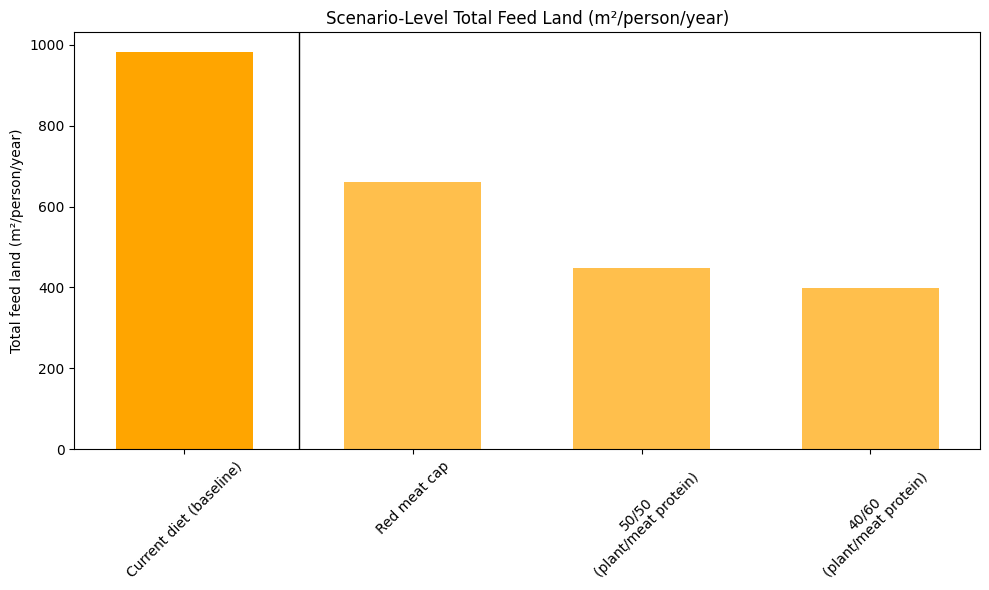


=== Summary Table: Total Feed Land ===
scenario
Current diet (baseline)        981.85
Red meat cap                   659.77
50/50\n(plant/meat protein)    447.16
40/60\n(plant/meat protein)    399.34
Name: total_land_pc, dtype: float64


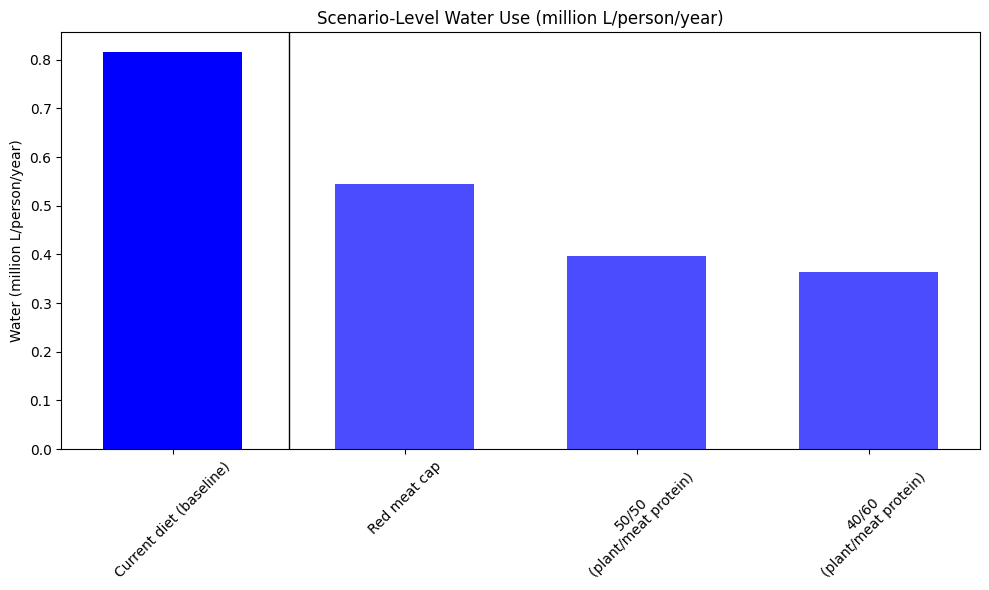


=== Summary Table: Water Use ===
scenario
Current diet (baseline)        0.82
Red meat cap                   0.54
50/50\n(plant/meat protein)    0.40
40/60\n(plant/meat protein)    0.36
Name: water_pc, dtype: float64


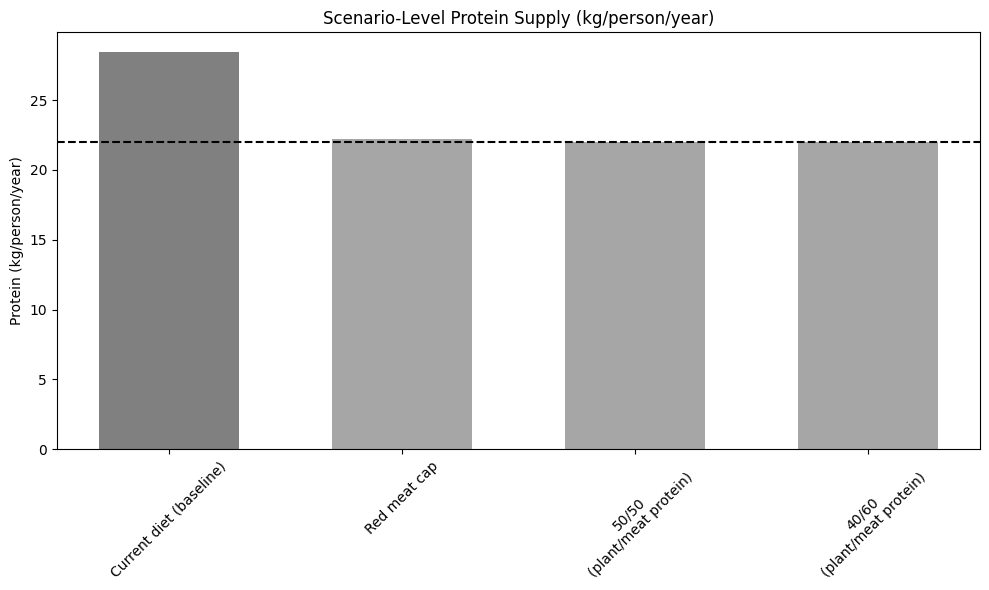


=== Summary Table: Protein Supply ===
scenario
Current diet (baseline)        28.43
Red meat cap                   22.21
50/50\n(plant/meat protein)    22.00
40/60\n(plant/meat protein)    22.00
Name: protein_pc, dtype: float64


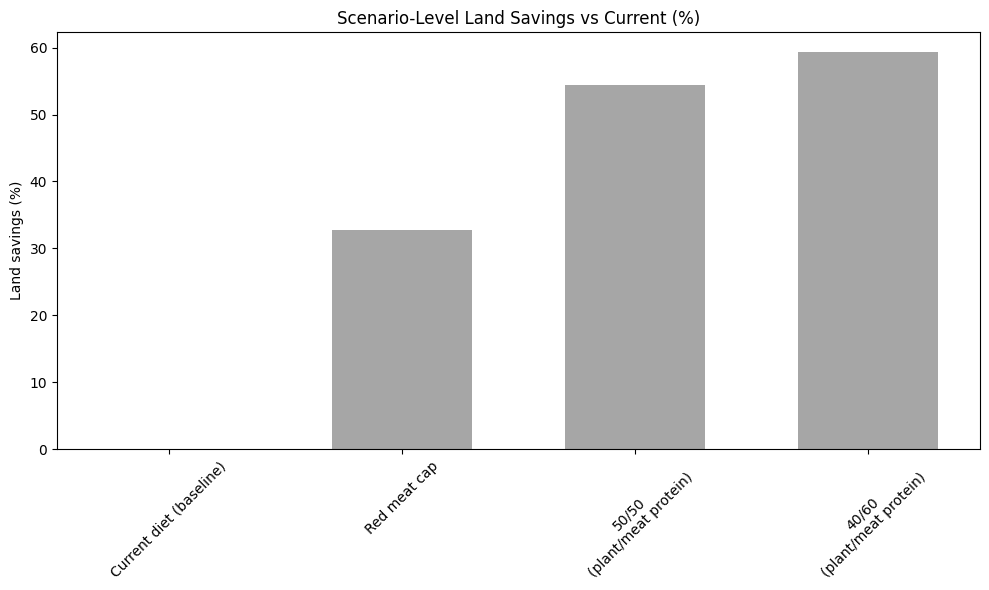


=== Summary Table: Land Savings (%) ===
scenario
Current diet (baseline)         0.00
Red meat cap                   32.80
50/50\n(plant/meat protein)    54.46
40/60\n(plant/meat protein)    59.33
Name: total_land_pc, dtype: float64


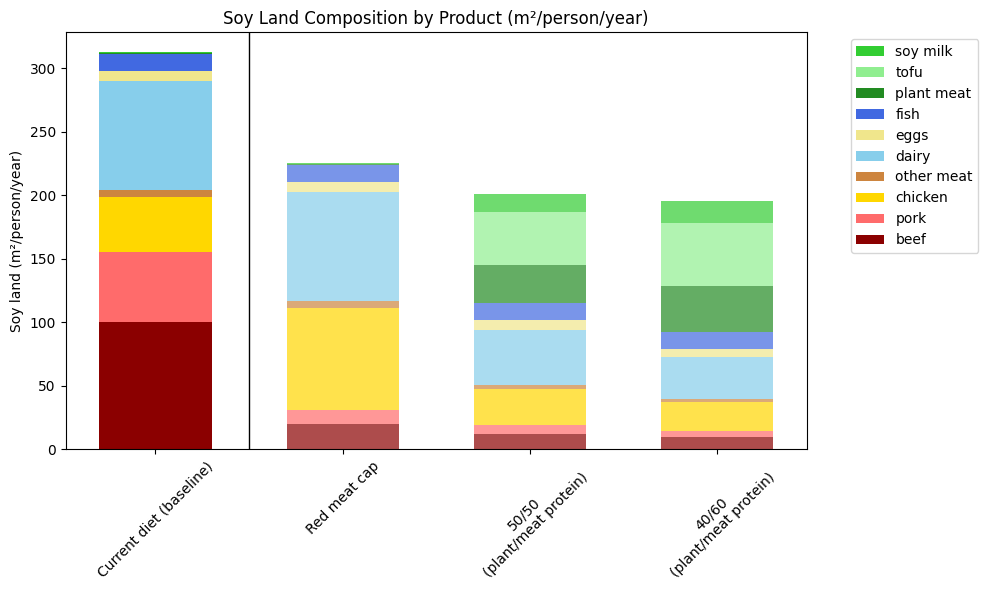


=== Summary Table: Soy Land by Product ===
product                       beef  chicken  dairy  eggs   fish  other_meat  \
scenario                                                                      
Current diet (baseline)      99.71    43.42  86.40  7.69  13.32        5.00   
Red meat cap                 19.94    80.21  86.40  7.69  13.32        5.00   
50/50\n(plant/meat protein)  11.97    28.94  43.20  7.69  13.32        3.00   
40/60\n(plant/meat protein)   9.26    22.40  33.44  5.95  13.32        2.32   

product                      plant_meat   pork  soy_milk   tofu  
scenario                                                         
Current diet (baseline)            0.52  55.50      0.73   0.17  
Red meat cap                       0.52  11.10      0.73   0.17  
50/50\n(plant/meat protein)       30.27   6.66     14.33  41.31  
40/60\n(plant/meat protein)       36.33   5.16     17.20  49.57  


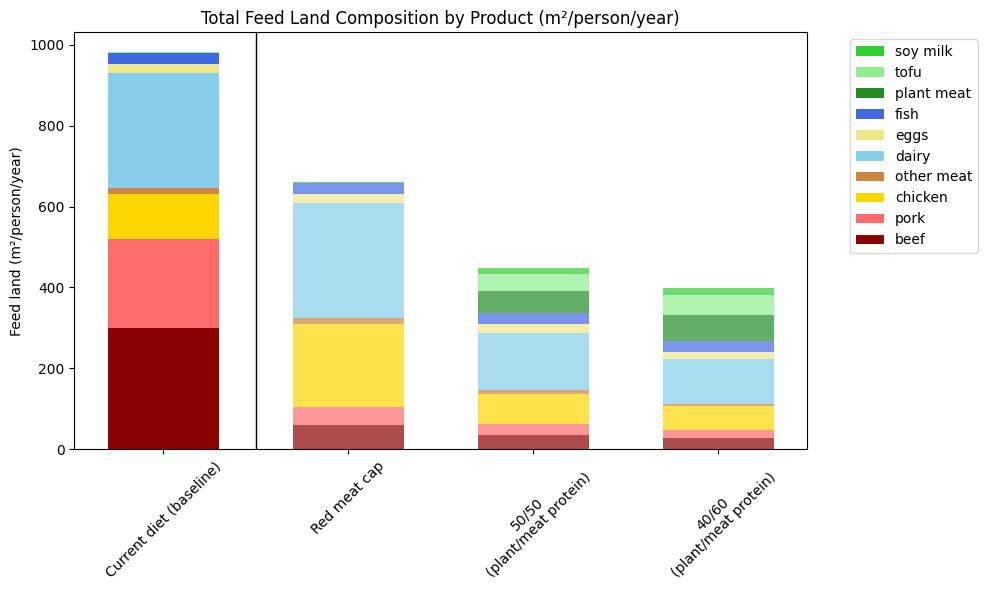


=== Summary Table: Total Feed Land by Product ===
product                        beef  chicken   dairy   eggs   fish  \
scenario                                                             
Current diet (baseline)      300.72   111.31  284.04  21.74  27.36   
Red meat cap                  60.14   205.61  284.04  21.74  27.36   
50/50\n(plant/meat protein)   36.09    74.17  142.02  21.74  27.36   
40/60\n(plant/meat protein)   27.94    57.42  109.94  16.83  27.36   

product                      other_meat  plant_meat    pork  soy_milk   tofu  
scenario                                                                      
Current diet (baseline)           15.09        0.94  219.76      0.73   0.17  
Red meat cap                      15.09        0.94   43.95      0.73   0.17  
50/50\n(plant/meat protein)        9.05       54.71   26.37     14.33  41.31  
40/60\n(plant/meat protein)        7.01       65.65   20.41     17.20  49.57  


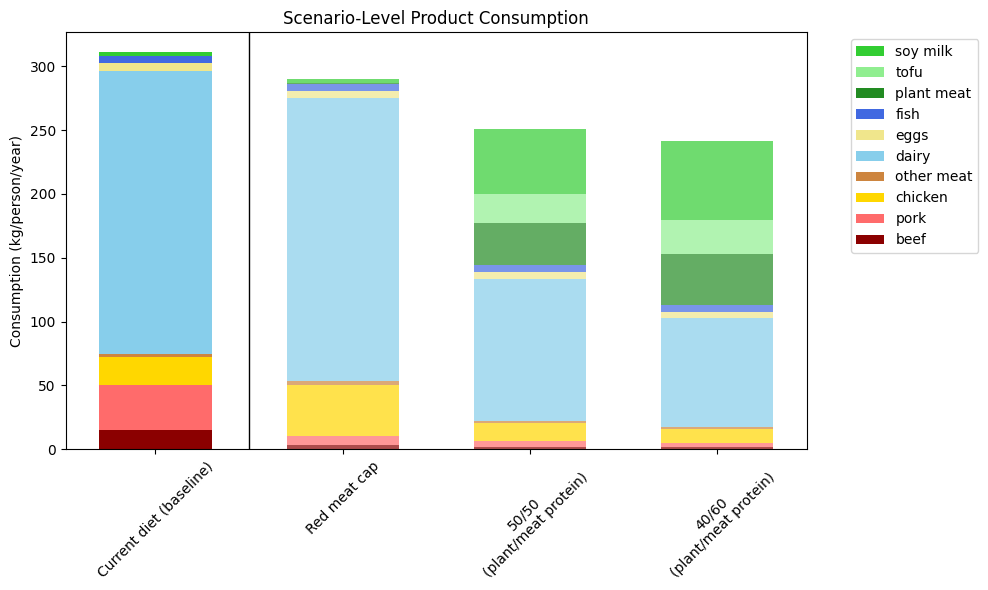


=== Summary Table: Product Consumption ===
product                       beef  chicken   dairy  eggs  fish  other_meat  \
scenario                                                                      
Current diet (baseline)      14.90    22.00  222.00  5.84  5.48        2.50   
Red meat cap                  2.98    40.64  222.00  5.84  5.48        2.50   
50/50\n(plant/meat protein)   1.79    14.66  111.00  5.84  5.48        1.50   
40/60\n(plant/meat protein)   1.38    11.35   85.93  4.52  5.48        1.16   

product                      plant_meat   pork  soy_milk   tofu  
scenario                                                         
Current diet (baseline)            0.57  35.10      2.61   0.09  
Red meat cap                       0.57   7.02      2.61   0.09  
50/50\n(plant/meat protein)       33.00   4.21     51.56  22.18  
40/60\n(plant/meat protein)       39.60   3.26     61.87  26.61  


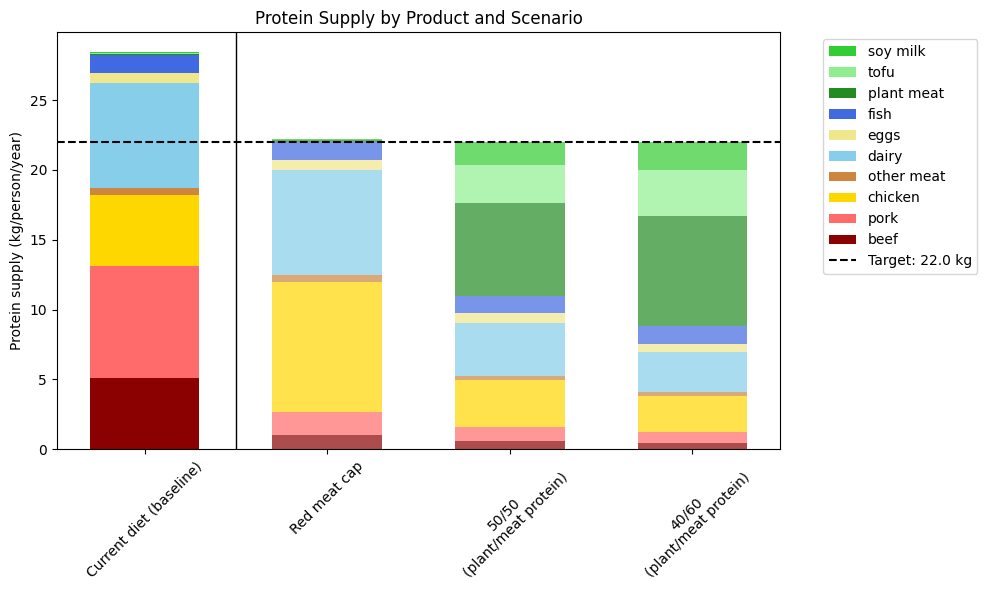


=== Summary Table: Protein Supply by Product ===
product                      beef  chicken  dairy  eggs  fish  other_meat  \
scenario                                                                    
Current diet (baseline)      5.07     5.06   7.55  0.72  1.26        0.50   
Red meat cap                 1.01     9.35   7.55  0.72  1.26        0.50   
50/50\n(plant/meat protein)  0.61     3.37   3.77  0.72  1.26        0.30   
40/60\n(plant/meat protein)  0.47     2.61   2.92  0.56  1.26        0.23   

product                      plant_meat  pork  soy_milk  tofu  
scenario                                                       
Current diet (baseline)            0.11  8.07      0.08  0.01  
Red meat cap                       0.11  1.61      0.08  0.01  
50/50\n(plant/meat protein)        6.60  0.97      1.65  2.75  
40/60\n(plant/meat protein)        7.92  0.75      1.98  3.30  


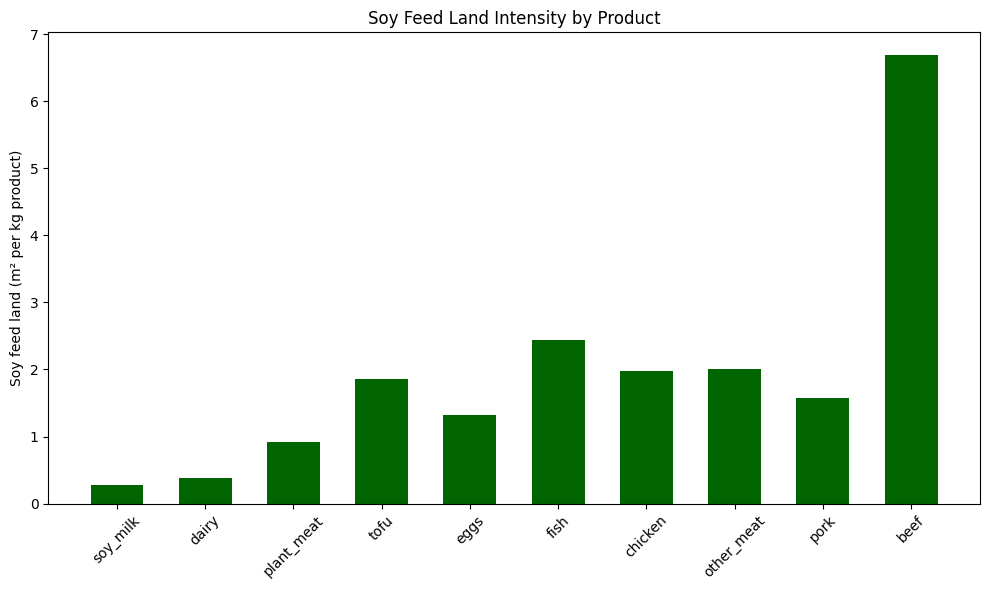


=== Summary Table: Soy Feed Land ===
      product  soy_land
9    soy_milk      0.28
6       dairy      0.39
5  plant_meat      0.92
8        tofu      1.86
7        eggs      1.32
4        fish      2.43
1     chicken      1.97
3  other_meat      2.00
0        pork      1.58
2        beef      6.69


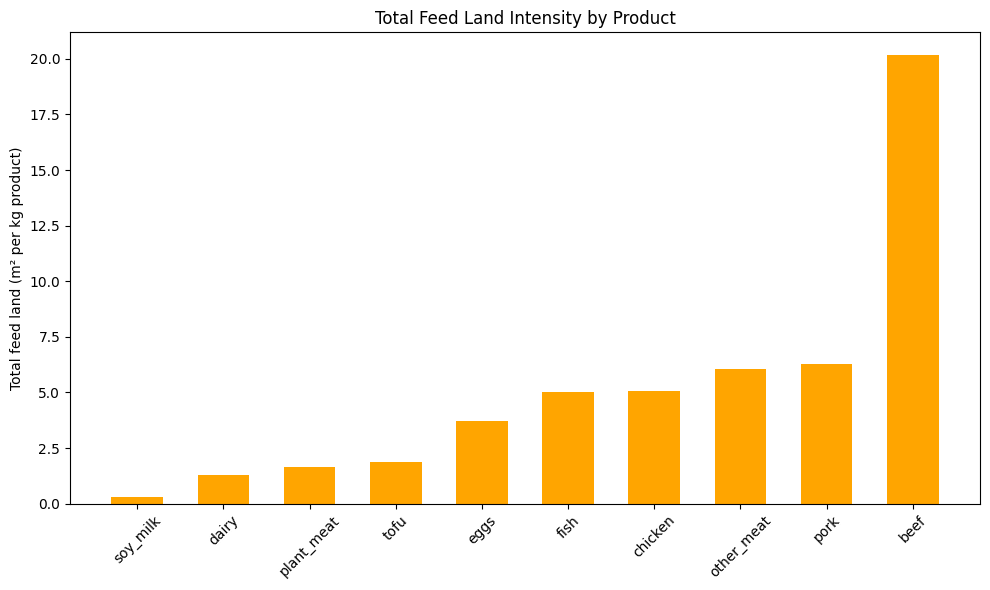


=== Summary Table: Total Feed Land ===
      product  total_land
9    soy_milk        0.28
6       dairy        1.28
5  plant_meat        1.66
8        tofu        1.86
7        eggs        3.72
4        fish        5.00
1     chicken        5.06
3  other_meat        6.04
0        pork        6.26
2        beef       20.18


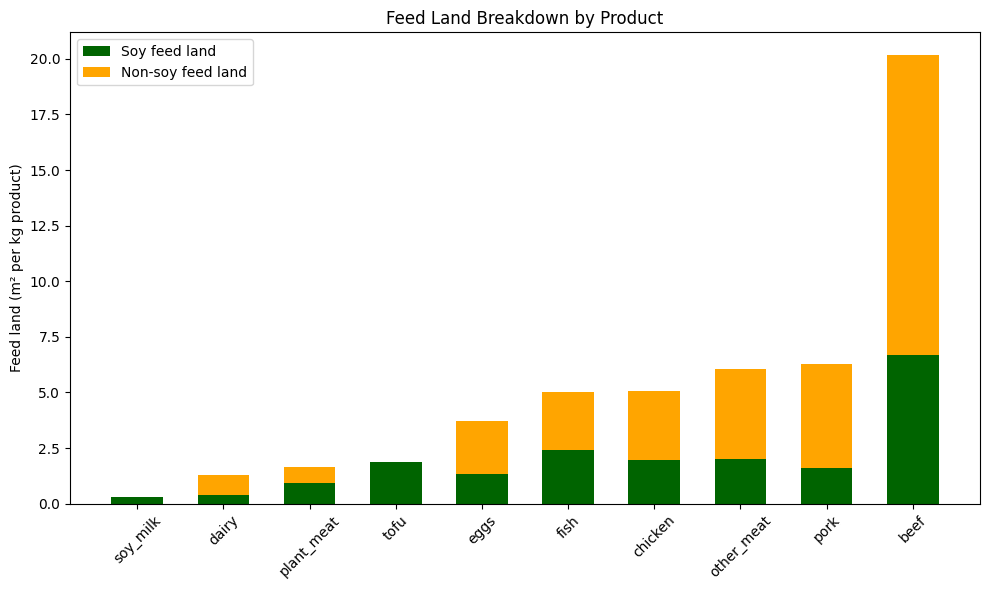


=== Summary Table: Feed Land Breakdown ===
      product  soy_land  non_soy_land
9    soy_milk      0.28          0.00
6       dairy      0.39          0.89
5  plant_meat      0.92          0.74
8        tofu      1.86          0.00
7        eggs      1.32          2.41
4        fish      2.43          2.57
1     chicken      1.97          3.09
3  other_meat      2.00          4.04
0        pork      1.58          4.68
2        beef      6.69         13.49


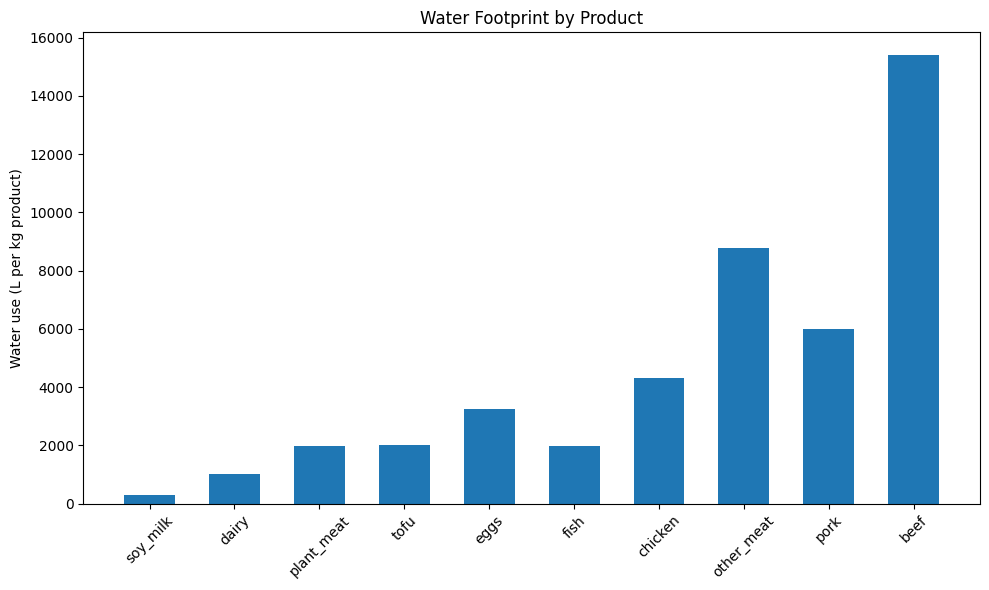


=== Summary Table: Water Footprint ===
      product  water_L_kg
9    soy_milk         297
6       dairy        1020
5  plant_meat        1973
8        tofu        2000
7        eggs        3265
4        fish        1974
1     chicken        4325
3  other_meat        8763
0        pork        5988
2        beef       15415


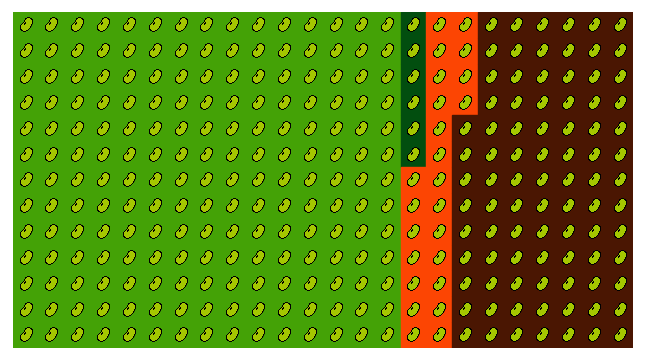

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

print("=== DUTCH PROTEIN DIETS: FOOD-FEED COMPETITION ===")

# ============================================
# 0. CONFIG
# ============================================
NL_POPULATION = 18_044_027  # 2025
PROTEIN_TARGET = 22.0  # kg protein/person/year

meat_2024_pc = {"pork": 35.1, "chicken": 22.0, "beef": 14.9, "other_meat": 2.5}
DAIRY_KG_PC = 222.0
EGGS_KG_PC = 5.840
FISH_KG_PC = 5.475
PLANT_MEAT_KG_PC = 10_200_000 / NL_POPULATION
TOFU_KG_PC = 1_630_000 / NL_POPULATION
SOY_MILK_KG_PC = 47_100_000 / NL_POPULATION

CROP_LAND_M2_KG = {"maize":0.97, "wheat":1.18, "barley":1.53, "rapeseed":2.65, "soy":2.78}

FEED_SHARES = {
    "dairy": {"maize":0.35, "soy":0.14, "wheat_barley":0.25, "rapeseed":0.08, "grass_hay":0.15, "other":0.03},
    "beef": {"maize":0.25, "soy":0.12, "wheat_barley":0.20, "rapeseed":0.06, "grass_hay":0.35, "other":0.02},
    "pork": {"maize":0.45, "soy":0.12, "wheat_barley":0.25, "rapeseed":0.08, "grass_hay":0.0, "other":0.10},
    "poultry": {"maize":0.55, "soy":0.20, "wheat_barley":0.15, "rapeseed":0.05, "grass_hay":0.0, "other":0.05},
    "eggs": {"maize":0.50, "soy":0.18, "wheat_barley":0.20, "rapeseed":0.06, "grass_hay":0.0, "other":0.06},
    "fish": {"maize":0.20, "soy":0.25, "wheat_barley":0.30, "rapeseed":0.05, "grass_hay":0.0, "other":0.20},
    "plant_meat": {"maize":0.15, "soy":0.33, "wheat_barley":0.40, "rapeseed":0.02, "grass_hay":0.0, "other":0.10},
}

prod_colors = {
    "beef": "#8B0000",
    "pork": "#FF6B6B",
    "chicken": "#FFD700",
    "other_meat": "#CD853F",
    "dairy": "#87CEEB",
    "eggs": "#F0E68C",
    "fish": "#4169E1",
    "plant_meat": "#228B22",
    "tofu": "#90EE90",
    "soy_milk": "#32CD32"
}

scenario_order = ["Current", "Red meat cap", "50/50", "40/60"]

# ============================================
# 1–4 unchanged
# ============================================
# (no changes in this section)

# ============================================
# 1. PRODUCTS DATAFRAME
# ============================================
products = [
    ("pork",4.74,230,"pork"),
    ("chicken",3.55,230,"poultry"),
    ("beef",20.06,340,"beef"),
    ("other_meat",6.00,200,"beef"),
    ("fish",3.50,230,"fish"),
    ("plant_meat",1.00,200,"plant_meat"),
    ("dairy",1,34,"dairy"),
    ("eggs",2.63,123,"eggs"),
    ("tofu",0.67,124,None),
    ("soy_milk",0.1,32,None)
]

df = pd.DataFrame(products, columns=["product","emcr","protein_g_kg","feed_type"])
df["soy_share"] = 0.0
df["soy_land"] = 0.0
df["non_soy_land"] = 0.0
df["total_land"] = 0.0
df["water_L_kg"] = [5988,4325,15415,8763,1974,1973,1020,3265,2000,297]

def compute_feed_land(emcr, feed_type):
    if feed_type is None:
        soy_land = emcr * CROP_LAND_M2_KG["soy"]
        return 1.0, soy_land, 0.0
    shares = FEED_SHARES[feed_type]
    soy_land = emcr * shares["soy"] * CROP_LAND_M2_KG["soy"]
    maize_kg = emcr * shares["maize"]
    wbar_kg = emcr * shares["wheat_barley"]
    rape_kg = emcr * shares["rapeseed"]
    non_soy_land = (
        maize_kg * CROP_LAND_M2_KG["maize"] +
        wbar_kg * (0.5*CROP_LAND_M2_KG["wheat"] + 0.5*CROP_LAND_M2_KG["barley"]) +
        rape_kg * CROP_LAND_M2_KG["rapeseed"]
    )
    return shares["soy"], soy_land, non_soy_land

for idx,row in df.iterrows():
    soy_share, soy_land, non_soy_land = compute_feed_land(row["emcr"], row["feed_type"])
    df.at[idx,"soy_share"]=soy_share
    df.at[idx,"soy_land"]=soy_land
    df.at[idx,"non_soy_land"]=non_soy_land
    df.at[idx,"total_land"]=soy_land+non_soy_land

# ============================================
# 2. HELPER FUNCTION
# ============================================
def add(rows, scenario, prod, kg):
    r = df.loc[df["product"]==prod].iloc[0]
    rows.append({
        "scenario": scenario,
        "product": prod,
        "kg_pc": kg,
        "protein_pc": kg * r.protein_g_kg / 1000,
        "soy_land_pc": kg * r.soy_land,
        "total_land_pc": kg * r.total_land,
        "water_pc": kg * r.water_L_kg
    })

# ============================================
# 3. SCENARIO BUILDER (FINAL LOGIC WITH OTHER MEAT)
# ============================================
def apply_red_meat_cap(animal_dict, cap_kg=10.0):
    """Apply red meat cap and fill chicken only to reach 22kg protein."""
    animal_new = animal_dict.copy()
    red_meat = ["beef","pork"]
    red_total = sum(animal_new[p] for p in red_meat)

    # Scale beef + pork if over cap
    if red_total > cap_kg:
        scale = cap_kg / red_total
        for p in red_meat:
            animal_new[p] *= scale

    # Compute total protein excluding chicken
    fixed_products = ["beef","pork","other_meat","dairy","eggs"]
    total_fixed_protein = sum([animal_new[p]*df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000
                               for p in fixed_products])
    total_protein_with_fish = total_fixed_protein + current_dict["fish"] * df.loc[df["product"]=="fish","protein_g_kg"].iloc[0]/1000

    # Determine chicken needed to reach exactly 22kg
    chicken_protein_per_kg = df.loc[df["product"]=="chicken","protein_g_kg"].iloc[0]/1000
    gap = PROTEIN_TARGET - total_protein_with_fish
    animal_new["chicken"] = max(0, gap / chicken_protein_per_kg)

    return animal_new


def build_scenarios():
    scenarios = []

    # --- Current diet ---
    global current_dict
    current_dict = {
        **meat_2024_pc,
        "dairy": DAIRY_KG_PC,
        "eggs": EGGS_KG_PC,
        "fish": FISH_KG_PC,
        "plant_meat": PLANT_MEAT_KG_PC,
        "tofu": TOFU_KG_PC,
        "soy_milk": SOY_MILK_KG_PC
    }

    for prod, kg in current_dict.items():
        add(scenarios,"Current",prod,kg)

    # Fixed animal protein from fish (never scaled)
    fixed_animal_protein = current_dict["fish"] * df.loc[df["product"]=="fish","protein_g_kg"].iloc[0]/1000

    # --- Red meat cap scenario ---
    animal_red = {p: current_dict[p] for p in ["beef","pork","chicken","dairy","other_meat","eggs"]}
    animal_red = apply_red_meat_cap(animal_red)

    # Add scenario
    for p, kg in animal_red.items():
        add(scenarios,"Red meat cap",p,kg)
    add(scenarios,"Red meat cap","fish",current_dict["fish"])
    for p in ["plant_meat","tofu","soy_milk"]:
        add(scenarios,"Red meat cap",p,current_dict[p])

    # --- 50/50 scenario ---
    animal_5050 = animal_red.copy()
    # Downscale beef/pork/other_meat by 10%, dairy by 50%, eggs scaled if needed
    for p in ["beef","pork","other_meat"]:
        animal_5050[p] *= 0.6
    animal_5050["dairy"] *= 0.5

    # Compute current animal protein excluding chicken
    animal_protein_fixed = sum([animal_5050[p]*df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000
                                for p in ["beef","pork","other_meat","dairy","eggs"]]) + fixed_animal_protein
    target_animal = PROTEIN_TARGET * 0.5
    gap = max(0,target_animal - animal_protein_fixed)

    # Chicken fills remaining animal protein
    chicken_protein_per_kg = df.loc[df["product"]=="chicken","protein_g_kg"].iloc[0]/1000
    animal_5050["chicken"] = gap / chicken_protein_per_kg

    # Plant protein = remaining to reach 22 kg
    plant_target = PROTEIN_TARGET - target_animal
    plant_shares = {"tofu":0.25,"plant_meat":0.6,"soy_milk":0.15}
    plant_5050 = {p: plant_target*plant_shares[p]/(df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000)
                   for p in plant_shares}

    # Add scenario
    for p, kg in animal_5050.items():
        add(scenarios,"50/50",p,kg)
    add(scenarios,"50/50","fish",current_dict["fish"])
    for p, kg in plant_5050.items():
        add(scenarios,"50/50",p,kg)

    # --- 40/60 scenario ---
    animal_4060 = animal_5050.copy()
    # Scale all animal products proportionally to meet 40% animal protein
    animal_protein_current = sum([animal_4060[p]*df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000
                                  for p in ["beef","pork","other_meat","dairy","eggs","chicken"]]) + fixed_animal_protein
    target_animal_4060 = PROTEIN_TARGET * 0.4
    scale_factor = max(0,(target_animal_4060 - fixed_animal_protein)/(animal_protein_current - fixed_animal_protein))
    for p in ["beef","pork","other_meat","dairy","eggs","chicken"]:
        animal_4060[p] *= scale_factor

    # Plant protein = remaining to reach 22 kg
    plant_target_4060 = PROTEIN_TARGET - target_animal_4060
    plant_4060 = {p: plant_target_4060*plant_shares[p]/(df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000)
                  for p in plant_shares}

    # Add scenario
    for p, kg in animal_4060.items():
        add(scenarios,"40/60",p,kg)
    add(scenarios,"40/60","fish",current_dict["fish"])
    for p, kg in plant_4060.items():
        add(scenarios,"40/60",p,kg)

    return pd.DataFrame(scenarios)

all_scenarios = build_scenarios()










# ============================================
# 4. SUMMARY TABLES
# ============================================
agg_pc = all_scenarios.groupby("scenario")[["soy_land_pc","total_land_pc","water_pc","protein_pc"]].sum().reindex(scenario_order)
print("\n=== SCENARIO SUMMARY ===")
print(agg_pc.round(2))

pivot = all_scenarios.pivot_table(index="scenario", columns="product", values="total_land_pc", aggfunc="sum", fill_value=0).reindex(scenario_order)
pivot_soy = all_scenarios.pivot_table(index="scenario", columns="product", values="soy_land_pc", aggfunc="sum", fill_value=0).reindex(scenario_order)
pivot_kg = all_scenarios.pivot_table(index="scenario", columns="product", values="kg_pc", aggfunc="sum", fill_value=0).reindex(scenario_order)
pivot_protein = all_scenarios.pivot_table(index="scenario", columns="product", values="protein_pc", aggfunc="sum", fill_value=0).reindex(scenario_order)

# Full summary table
summary_table = agg_pc.join(pivot_kg.add_suffix("_kg")).join(pivot_protein.add_suffix("_protein"))
print("\n=== Full Scenario Summary Table ===")
print(summary_table.round(2))

# ============================================
# 5. SCENARIO-LEVEL PLOTS (WITH SUMMARY TABLES)
# ============================================

# Friendly names for legend
legend_names = {
    "beef": "beef",
    "pork": "pork",
    "chicken": "chicken",
    "other_meat": "other meat",
    "dairy": "dairy",
    "eggs": "eggs",
    "fish": "fish",
    "plant_meat": "plant meat",
    "tofu": "tofu",
    "soy_milk": "soy milk"
}

# Product order for stacked bars (keep original order)
plot_order = list(prod_colors.keys())

# Reverse legend order (beef last)
legend_order = plot_order[::-1]

# Adjust scenario style for baseline name
scenario_style_plot = {
    "Current diet (baseline)": {"alpha": 1.0},
    "Red meat cap": {"alpha": 0.7},
    "50/50\n(plant/meat protein)": {"alpha": 0.7},
    "40/60\n(plant/meat protein)": {"alpha": 0.7},
}

# Map original agg_pc and pivot indexes to new scenario names
rename_dict = {
    "Current": "Current diet (baseline)",
    "50/50": "50/50\n(plant/meat protein)",
    "40/60": "40/60\n(plant/meat protein)"
}

agg_pc_plot = agg_pc.rename(index=rename_dict)
pivot_soy_plot = pivot_soy.rename(index=rename_dict)
pivot_plot = pivot.rename(index=rename_dict)
pivot_kg_plot = pivot_kg.rename(index=rename_dict)
pivot_protein_plot = pivot_protein.rename(index=rename_dict)

# -----------------------
# Scenario-Level Soy Land
# -----------------------
plt.figure(figsize=(10,6))
for sc in agg_pc_plot.index:
    plt.bar(sc, agg_pc_plot.loc[sc, "soy_land_pc"], color="darkgreen", alpha=scenario_style_plot[sc]["alpha"], width=0.6)
plt.axvline(x=list(agg_pc_plot.index).index("Current diet (baseline)")+0.5, color="black", linewidth=1)
plt.title("Scenario-Level Soy Land (m²/person/year)")
plt.ylabel("Soy land (m²/person/year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n=== Summary Table: Soy Land ===")
print(agg_pc_plot["soy_land_pc"].round(2))

# -----------------------
# Scenario-Level Total Feed Land
# -----------------------
plt.figure(figsize=(10,6))
for sc in agg_pc_plot.index:
    plt.bar(sc, agg_pc_plot.loc[sc, "total_land_pc"], color="orange", alpha=scenario_style_plot[sc]["alpha"], width=0.6)
plt.axvline(x=list(agg_pc_plot.index).index("Current diet (baseline)")+0.5, color="black", linewidth=1)
plt.title("Scenario-Level Total Feed Land (m²/person/year)")
plt.ylabel("Total feed land (m²/person/year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n=== Summary Table: Total Feed Land ===")
print(agg_pc_plot["total_land_pc"].round(2))

# -----------------------
# Scenario-Level Water Use
# -----------------------
plt.figure(figsize=(10,6))
for sc in agg_pc_plot.index:
    plt.bar(sc, agg_pc_plot.loc[sc, "water_pc"]/1e6, color="blue", alpha=scenario_style_plot[sc]["alpha"], width=0.6)
plt.axvline(x=list(agg_pc_plot.index).index("Current diet (baseline)")+0.5, color="black", linewidth=1)
plt.title("Scenario-Level Water Use (million L/person/year)")
plt.ylabel("Water (million L/person/year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n=== Summary Table: Water Use ===")
print((agg_pc_plot["water_pc"]/1e6).round(2))

# -----------------------
# Scenario-Level Protein Supply
# -----------------------
plt.figure(figsize=(10,6))
for sc in agg_pc_plot.index:
    plt.bar(sc, agg_pc_plot.loc[sc, "protein_pc"], color="grey", alpha=scenario_style_plot[sc]["alpha"], width=0.6)
plt.axhline(y=PROTEIN_TARGET, color="black", linestyle="--", label=f"Target: {PROTEIN_TARGET} kg")
plt.title("Scenario-Level Protein Supply (kg/person/year)")
plt.ylabel("Protein (kg/person/year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n=== Summary Table: Protein Supply ===")
print(agg_pc_plot["protein_pc"].round(2))

# -----------------------
# Scenario-Level Land Savings
# -----------------------
plt.figure(figsize=(10,6))
current_total = agg_pc_plot.loc["Current diet (baseline)","total_land_pc"]
for sc in agg_pc_plot.index:
    saving = (1 - agg_pc_plot.loc[sc, "total_land_pc"] / current_total) * 100
    plt.bar(sc, saving, color="grey", alpha=scenario_style_plot[sc]["alpha"], width=0.6)
plt.title("Scenario-Level Land Savings vs Current (%)")
plt.ylabel("Land savings (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n=== Summary Table: Land Savings (%) ===")
land_saving_table = (1 - agg_pc_plot["total_land_pc"] / current_total) * 100
print(land_saving_table.round(2))

# -----------------------
# Soy Land Composition (stacked)
# -----------------------
plt.figure(figsize=(10,6))
bottom = np.zeros(len(pivot_soy_plot))
for prod in plot_order:
    if prod in pivot_soy_plot.columns:
        for i, sc in enumerate(pivot_soy_plot.index):
            plt.bar(sc, pivot_soy_plot.loc[sc, prod], bottom=bottom[i], color=prod_colors[prod],
                    alpha=scenario_style_plot[sc]["alpha"], width=0.6, label=legend_names[prod] if i==0 else None)
        bottom += pivot_soy_plot[prod].values
plt.axvline(x=list(pivot_soy_plot.index).index("Current diet (baseline)")+0.5, color="black", linewidth=1)
plt.title("Soy Land Composition by Product (m²/person/year)")
plt.ylabel("Soy land (m²/person/year)")
plt.xticks(rotation=45)
plt.legend(reversed(plt.gca().get_legend_handles_labels()[0]),
           reversed(plt.gca().get_legend_handles_labels()[1]),
           bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()
print("\n=== Summary Table: Soy Land by Product ===")
print(pivot_soy_plot.round(2))

# -----------------------
# Total Feed Land Composition (stacked)
# -----------------------
plt.figure(figsize=(10,6))
bottom = np.zeros(len(pivot_plot))
for prod in plot_order:
    if prod in pivot_plot.columns:
        for i, sc in enumerate(pivot_plot.index):
            plt.bar(sc, pivot_plot.loc[sc, prod], bottom=bottom[i], color=prod_colors[prod],
                    alpha=scenario_style_plot[sc]["alpha"], width=0.6, label=legend_names[prod] if i==0 else None)
        bottom += pivot_plot[prod].values
plt.axvline(x=list(pivot_plot.index).index("Current diet (baseline)")+0.5, color="black", linewidth=1)
plt.title("Total Feed Land Composition by Product (m²/person/year)")
plt.ylabel("Feed land (m²/person/year)")
plt.xticks(rotation=45)
plt.legend(reversed(plt.gca().get_legend_handles_labels()[0]),
           reversed(plt.gca().get_legend_handles_labels()[1]),
           bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()
print("\n=== Summary Table: Total Feed Land by Product ===")
print(pivot_plot.round(2))

# -----------------------
# Product Consumption (stacked)
# -----------------------
fig, ax = plt.subplots(figsize=(10,6))
bottom = np.zeros(len(pivot_kg_plot))
for prod in plot_order:
    if prod in pivot_kg_plot.columns:
        for i, sc in enumerate(pivot_kg_plot.index):
            ax.bar(sc, pivot_kg_plot.loc[sc, prod], bottom=bottom[i], color=prod_colors[prod],
                   alpha=scenario_style_plot[sc]["alpha"], width=0.6, label=legend_names[prod] if i==0 else None)
        bottom += pivot_kg_plot[prod].values
ax.axvline(x=list(pivot_kg_plot.index).index("Current diet (baseline)")+0.5, color="black", linewidth=1)
ax.set_ylabel("Consumption (kg/person/year)")
ax.set_title("Scenario-Level Product Consumption")
ax.legend(reversed(plt.gca().get_legend_handles_labels()[0]),
           reversed(plt.gca().get_legend_handles_labels()[1]),
           bbox_to_anchor=(1.05,1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n=== Summary Table: Product Consumption ===")
print(pivot_kg_plot.round(2))

# -----------------------
# Protein Supply by Product (stacked)
# -----------------------
fig, ax = plt.subplots(figsize=(10,6))
bottom = np.zeros(len(pivot_protein_plot))
for prod in plot_order:
    if prod in pivot_protein_plot.columns:
        for i, sc in enumerate(pivot_protein_plot.index):
            ax.bar(sc, pivot_protein_plot.loc[sc, prod], bottom=bottom[i], color=prod_colors[prod],
                   alpha=scenario_style_plot[sc]["alpha"], width=0.6, label=legend_names[prod] if i==0 else None)
        bottom += pivot_protein_plot[prod].values
ax.axvline(x=list(pivot_protein_plot.index).index("Current diet (baseline)")+0.5, color="black", linewidth=1)
ax.axhline(y=PROTEIN_TARGET, color="black", linestyle="--", label=f"Target: {PROTEIN_TARGET} kg")
ax.set_ylabel("Protein supply (kg/person/year)")
ax.set_title("Protein Supply by Product and Scenario")
ax.legend(reversed(plt.gca().get_legend_handles_labels()[0]),
           reversed(plt.gca().get_legend_handles_labels()[1]),
           bbox_to_anchor=(1.05,1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n=== Summary Table: Protein Supply by Product ===")
print(pivot_protein_plot.round(2))

# ==============================
# Product-Level Feed Land & Water
# ==============================
df_sorted = df.sort_values("total_land")

# Soy feed land per product
plt.figure(figsize=(10,6))
plt.bar(df_sorted["product"], df_sorted["soy_land"], color="darkgreen", width=0.6)
plt.ylabel("Soy feed land (m² per kg product)")
plt.title("Soy Feed Land Intensity by Product")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n=== Summary Table: Soy Feed Land ===")
print(df_sorted[["product","soy_land"]].round(2))

# Total feed land per product
plt.figure(figsize=(10,6))
plt.bar(df_sorted["product"], df_sorted["total_land"], color="orange", width=0.6)
plt.ylabel("Total feed land (m² per kg product)")
plt.title("Total Feed Land Intensity by Product")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n=== Summary Table: Total Feed Land ===")
print(df_sorted[["product","total_land"]].round(2))

# Feed land breakdown (soy vs non-soy)
plt.figure(figsize=(10,6))
bottom = np.zeros(len(df_sorted))
plt.bar(df_sorted["product"], df_sorted["soy_land"], bottom=bottom, color="darkgreen", width=0.6, label="Soy feed land")
bottom += df_sorted["soy_land"].values
plt.bar(df_sorted["product"], df_sorted["non_soy_land"], bottom=bottom, color="orange", width=0.6, label="Non-soy feed land")
plt.ylabel("Feed land (m² per kg product)")
plt.title("Feed Land Breakdown by Product")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n=== Summary Table: Feed Land Breakdown ===")
print(df_sorted[["product","soy_land","non_soy_land"]].round(2))

# Water footprint per product
plt.figure(figsize=(10,6))
plt.bar(df_sorted["product"], df_sorted["water_L_kg"], color="tab:blue", width=0.6)
plt.ylabel("Water use (L per kg product)")
plt.title("Water Footprint by Product")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n=== Summary Table: Water Footprint ===")
print(df_sorted[["product","water_L_kg"]].round(2))


#############
### soybean waffle plot ###
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Soy land per scenario (rounded for visualization) #tb checked again
soy_land_pc = {
    "Current": 312,
    "Red meat cap": 225,
    "50/50": 201,
    "40/60": 195
}

# Order from lowest to highest so each scenario shows the difference
scenario_order = ["40/60", "50/50", "Red meat cap", "Current"]

# Colors for scenarios
colors = {
    "40/60": "#44a206",
    "50/50": "#024e0f",
    "Red meat cap": "#fc4503",
    "Current": "#4A1602"
}

# Load soybean icon (transparent PNG)
icon_path = "soybean.png"
soy_icon = Image.open(icon_path)

# Waffle grid config
n_cols = 24
n_rows = 13
max_cells = n_cols * n_rows
icon_zoom = 0.05  # adjust depending on PNG size

# Compute scenario differences (to know how many squares each scenario adds)
prev = 0
scenario_diff = {}
for sc in scenario_order:
    scenario_diff[sc] = soy_land_pc[sc] - prev
    prev = soy_land_pc[sc]

# Create figure
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')

# Remove axes, ticks, and spines
ax.set_xlim(0, n_cols)
ax.set_ylim(0, n_rows)
ax.axis('off')  # hides all ticks, labels, and spines

# Draw the background squares for each scenario
# Draw the background squares for each scenario (column-first)
current_idx = 0
for sc in scenario_order:
    for i in range(scenario_diff[sc]):
        # Column-first: x = column, y = row
        x = current_idx // n_rows
        y = n_rows - 1 - (current_idx % n_rows)
        ax.add_patch(plt.Rectangle((x, y), 1, 1, color=colors[sc], zorder=0))
        current_idx += 1

# Overlay soybean PNGs on every square (column-first)
for i in range(prev):  # prev = total squares
    x = i // n_rows
    y = n_rows - 1 - (i % n_rows)
    imagebox = OffsetImage(soy_icon, zoom=icon_zoom)
    ab = AnnotationBbox(imagebox, (x+0.5, y+0.5), frameon=False, zorder=1)
    ax.add_artist(ab)




plt.show()
